# Credits

This is heavily influenced from https://github.com/pytorch/tutorials

# CIFAR-10

In thins notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.
The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

![cifar10](../static_files/cifar10.png)


In order to train a classifier the following steps needs to be performed:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

We will help you along the way.
We indicate the places you need to modify the code with `# Your code here!`.
It is however a good idea to read the entire assignment before you begin coding!

## 1. Loading and normalizing CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1]

**NB** Modify the code below to only use a small part of the dataset if your computer is very slow.

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),
                          (0.5, 0.5, 0.5))]
)

# Load dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
print()

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

used_categories = range(len(classes))

## USE CODE BELOW IF YOUR COMPUTER IS TOO SLOW
reduce_dataset = True
if reduce_dataset:
    used_categories = (3, 5) # cats and dogs

    classes = [classes[i] for i in used_categories]
    new_train_data = []
    new_train_labels = []

    new_test_data = []
    new_test_labels = []
    for i, t in enumerate(used_categories):
        new_train_data.append(trainset.train_data[np.where(np.array(trainset.train_labels) == t)])
        new_train_labels += [i for _ in range(new_train_data[-1].shape[0])]

        new_test_data.append(testset.test_data[np.where(np.array(testset.test_labels) == t)])
        new_test_labels += [i for _ in range(new_test_data[-1].shape[0])]

    new_train_data = np.concatenate(new_train_data, 0)
    trainset.train_data = new_train_data
    trainset.train_labels = new_train_labels

    new_test_data = np.concatenate(new_test_data, 0)
    testset.test_data = new_test_data
    testset.test_labels = new_test_labels

    
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2)
train_data_iter = iter(trainloader)
test_data_iter = iter(testloader)
print('used classes:', classes)

Files already downloaded and verified
Files already downloaded and verified

used classes: ['cat', 'dog']


In [4]:
print("Training data")
print(trainset.train_data.shape)
print(len(trainset.train_labels))
print()

print("Test data")
print(testset.test_data.shape)
print(len(testset.test_labels))
print()

Training data
(10000, 32, 32, 3)
10000

Test data
(2000, 32, 32, 3)
2000



Let us show some of the training images, for fun.



  cat   dog   cat   cat


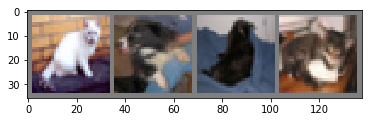

In [5]:
# Run this cell multiple time to see more samples

def imshow(img):
    """ show an image """
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
images, labels = train_data_iter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolutional Neural Network

**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully come back and improve the architecture

In [6]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

def compute_conv_dim(dim_size, kernel_size,padding,stride):
    return int((dim_size - kernel_size + 2 * padding) / stride + 1)

channels = trainset.train_data.shape[3]
height = trainset.train_data.shape[1]
width = trainset.train_data.shape[2]
class Net(nn.Module):
    def __init__(self, num_classes):       
        super(Net, self).__init__()
        self.input_channels = channels
        self.input_height = height
        self.input_width =width
        self.num_classes = num_classes
        self.num_filters_conv1 = 16
        self.kernel_size_conv1 = 5
        self.stride_conv1 = 1
        self.padding_conv1 = 2
        self.kernel_size_pool1=2
        self.stride_pool1=1
        self.num_filters_conv2 = 16
        self.kernel_size_conv2 = 5
        self.stride_conv2 = 1
        self.padding_conv2 = 2
        self.kernel_size_pool2=2
        self.stride_pool2=1
        
        self.conv_1 = Conv2d(in_channels=self.input_channels,
                            out_channels=self.num_filters_conv1,
                            kernel_size=self.kernel_size_conv1,
                            stride=self.stride_conv1, padding=self.padding_conv1)
        self.conv_1_out_height=compute_conv_dim(self.input_height,self.kernel_size_conv1,self.padding_conv1,self.stride_conv1)
        self.conv_1_out_width =compute_conv_dim(self.input_width,self.kernel_size_conv1,self.padding_conv1,self.stride_conv1)
        self.batchnorm1 =BatchNorm2d(self.num_filters_conv1,self.conv_1_out_height,self.conv_1_out_width)
        self.maxpool1 =MaxPool2d(kernel_size=self.kernel_size_pool1,stride=self.stride_pool1)
        self.conv2_input_height = (self.conv_1_out_height-1)
        self.conv2_input_width  = (self.conv_1_out_width-1)
        
        self.conv_2 = Conv2d(in_channels=self.num_filters_conv1,
                            out_channels=self.num_filters_conv2,
                            kernel_size=self.kernel_size_conv2,
                            stride=self.stride_conv2, padding=self.padding_conv2)
        self.conv_2_out_height=compute_conv_dim(self.conv2_input_height,self.kernel_size_conv2,self.padding_conv2,self.stride_conv2)
        self.conv_2_out_width =compute_conv_dim(self.conv2_input_width,self.kernel_size_conv2,self.padding_conv2,self.stride_conv2)
        self.batchnorm1 =BatchNorm2d(self.num_filters_conv2,self.conv_2_out_height,self.conv_2_out_width)
        self.maxpool2 =MaxPool2d(kernel_size=self.kernel_size_pool2,stride=self.stride_pool2)

        
        self.l1_in_features = self.num_filters_conv2 * (self.conv_2_out_height-1) * (self.conv_2_out_width-1)
        self.dropout = Dropout2d(p=0.5)
        self.num_l1 = 100
        self.l_1 = Linear(in_features=self.l1_in_features, 
                          out_features=self.num_l1,
                          bias=True)
        self.l_out = Linear(in_features=self.num_l1, 
                            out_features=self.num_classes,
                            bias=False)
    
    def forward(self, x):
        x = relu(self.conv_1(x))
        x = self.batchnorm1(x)
        x = self.maxpool1(x)
        x = relu(self.conv_2(x))
        x = self.batchnorm1(x)
        x = self.maxpool2(x)
        x = x.view(-1, self.l1_in_features)
        x = self.dropout(relu(self.l_1(x)))
        return softmax(self.l_out(x), dim=1)        
    

net = Net(len(used_categories))
print(net)

Net(
  (conv_1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchnorm1): BatchNorm2d(16, eps=31, momentum=31, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.5)
  (l_1): Linear(in_features=14400, out_features=100, bias=True)
  (l_out): Linear(in_features=100, out_features=2, bias=False)
)


## 3. Define a Loss function and optimizer

**Assignment 2:** Implement the criterion and optimizer. 
We suggest Classification Cross-Entropy loss and SGD with momentum.
You might need to experiment a bit with the learning rate.

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-6)

## 4. Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 3).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [8]:
num_epoch = 5  # Your code here!
net.train()
for epoch in range(num_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = net(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[1,  1000] loss: 0.676
[1,  2000] loss: 0.646
[2,  1000] loss: 0.640
[2,  2000] loss: 0.625
[3,  1000] loss: 0.623
[3,  2000] loss: 0.619
[4,  1000] loss: 0.598
[4,  2000] loss: 0.598
[5,  1000] loss: 0.577
[5,  2000] loss: 0.586
Finished Training


## 5. Test the network on the test data

Now we need to check if the network has learnt anything at all.
We will check this by predicting the class label that the neural network outputs, and checking it against the ground truth.
If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

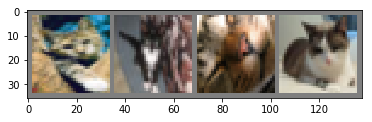

GroundTruth:     cat   cat   cat   cat
Predicted:       cat   dog   cat   cat


In [9]:
images, labels = test_data_iter.next()
outputs=net(Variable(images))
# print images
imshow(torchvision.utils.make_grid(images))
plt.show()

print('GroundTruth:  ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

_, predicted = torch.max(outputs.data, 1)
print('Predicted:    ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Let us look at how the network performs on the whole dataset.

In [10]:
correct = 0
total = 0

for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the {} test images: {:4.2f} %'.format(
    testset.test_data.shape[0], 100 * correct / total))

Accuracy of the network on the 2000 test images: 69.00 %


Hopefully the network is better than chance, which is $\frac{1}{\text{number of classes}}$ accuracy (randomly picking
a class).


We can also examine which class the network found the most difficult (makes more sense if you have many clases):

In [11]:
class_total = list(0. for i in range(len(classes)))
class_correct = list(0. for i in range(len(classes)))

for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    
    for i in range(len(c)):
        label = labels[i]
        class_correct[label] += c[i].numpy()
        class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of {:5s} : {:5.2f} %'.format(
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of cat   : 61.30 %
Accuracy of dog   : 75.50 %


**Assignment 4:** 
1. Go back and improve performance of the network. 
 * If you are using all 10 classes you should get a test accuracy above 55%, but see how much further you can get it!
 * If you are using only 2 classes (e.g. cat and dog) you should get a test accuracy above 60%, but see how much further you can get it!

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?

3. Write down key lessons/insights you got (if any) during this exercise.

**Answer:**


1: Have only set up on CPU for now(Will look into GPU this week), so are using 2 classes and only 5 epochs to make me able to train and see the improvements in a faster.


2:
Start network: 63 % correct

What i tried to do:<br>
Added a secound identical layer<br>
Added Max pooling after both layers<br>
Changed the number of filters to a higher number<br>
Added Dropout<br>
Added Batchnomalization<br>


What i could have done:<br>
Different kernel size<br>
Add moment to optimizer<br>
Changed hyperparameters of the optimizer<br>
Different layer sizes<br>


Improved network: 69 % correct


3:
Given i have only run it on 5 epochs that basicly invalidates every result I have, for what the best network is.
I can only say which of the networks trains a bit faster in the beginning of a training. Therefore i have not shown the results of each different change.But I can see that there is a lot you can do to optimize you code for a given problem. <br>
In general most important lessen I have learned is that i need GPU, to get real results, and will get that setup quickly. 

# Training on GPU

**Optional Assignment:**
If you have a GPU we suggest that you try and rewrite the code above to run on the GPU
___

Just like how you transfer a Tensor on to the GPU, you transfer the neural net onto the GPU.
This will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

```
    net.cuda()
```

Remember that you will have to send the inputs and targets at every step to the GPU too:

```
    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
```

Why dont I notice MASSIVE speedup compared to CPU? 
Because your network is realllly small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images




# Michael Nielsen book exercise of own choice

**Assignment 5:** Pick an exercise of own choice from [Michael Nielsens book](http://neuralnetworksanddeeplearning.com/)

**Answer:**
I have picked http://neuralnetworksanddeeplearning.com/chap1.html#exercise_263792:

Given we have a  mini-batch of size 1, that means that we make a change to the network for each data point. So in one epoch we take a lot of more steps in our gradient descent. Depending on our seach space this might be a good idea. This is a better argument for problems where the data-set i quite small, because then we still get a siable number of changes per epoch.

With bigger mini-batch sizes of say 20 we average over the outcomes, if we are unlucky ennough this might cancel out the gradient in some directions of our high dimensional search. This will not happen for online learning, but will also have downsides.

A downside is that "outliers" in the dataset, and by this i don't mean statiscial outlier, but datapoints that are quite different from the others. These points may depending on the learning rate have a bigger influence on our search and thereby slow it down.

Another downside is that this is slower to get through a epoch, which if they are quite large makes online training a poor choice. 

A last downside is noise in our data. Given we do a change for every datapoint, then the individual noice of the datapoints have a big influence on the gradient descent. If the noise is high ennough the training basicaly becomes a random walk. This is mitigated through the averaging with higher minibatch sizes. 


